In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

# Function to fetch stock data and preprocess it
def fetch_data(ticker, start_date, end_date):
    # Fetch stock data from Yahoo Finance
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        print("No data fetched. Please check the ticker or date range.")
        return None
    return data

# Function to prepare the dataset for training
def create_dataset(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Bayesian Neural Network Model
class BayesianNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.3):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Train and predict with Bayesian Neural Network
def train_bnn(X_train, y_train, X_test):
    model = BayesianNN(input_dim=X_train.shape[1], hidden_dim=64, output_dim=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    # Convert to PyTorch tensors and ensure the correct shape
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)

    # Ensure the input has the correct shape
    X_train = X_train.view(X_train.size(0), -1)  # Flatten the input
    X_test = X_test.view(X_test.size(0), -1)    # Flatten the input similarly

    # Training loop
    epochs = 500
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()

    # Predictions
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).numpy()

    return predictions, model

# Build and train LSTM model
def train_lstm(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    predictions = model.predict(X_test)

    return predictions, model

# Build and train GRU model
def train_gru(X_train, y_train, X_test):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(GRU(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    predictions = model.predict(X_test)

    return predictions, model

def predict_future_prices(model, scaler, data, time_step, future_days, model_type='LSTM'):
    last_data = data[-time_step:]
    last_data = last_data.reshape(1, time_step, 1)
    
    future_predictions = []
    
    for _ in range(future_days):
        if model_type == 'LSTM' or model_type == 'GRU':
            future_pred = model.predict(last_data)
        else:
            future_pred = model(torch.tensor(last_data, dtype=torch.float32).view(1, -1)).detach().numpy()  # Detach before .numpy()

        future_predictions.append(future_pred[0, 0])
        last_data = np.append(last_data[:, 1:, :], future_pred.reshape(1, 1, 1), axis=1)

    # Inverse transform the predicted prices
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions

# Function to generate various plots
def plot_stock_price(data):
    plt.plot(data['Close'], color='blue', label='Stock Price')
    plt.title('Stock Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def plot_moving_averages(data):
    data['50_MA'] = data['Close'].rolling(window=50).mean()
    data['200_MA'] = data['Close'].rolling(window=200).mean()
    plt.plot(data['Close'], color='blue', label='Stock Price')
    plt.plot(data['50_MA'], color='orange', label='50-Day MA')
    plt.plot(data['200_MA'], color='green', label='200-Day MA')
    plt.title('Stock Price and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def plot_candlestick(data):
    import plotly.graph_objects as go
    fig = go.Figure(data=[go.Candlestick(x=data.index,
                                         open=data['Open'],
                                         high=data['High'],
                                         low=data['Low'],
                                         close=data['Close'])])
    fig.update_layout(title='Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
    fig.show()

def plot_volume(data):
    plt.bar(data.index, data['Volume'], color='gray')
    plt.title('Stock Trading Volume')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.show()

def plot_rsi(data):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    plt.plot(data.index, rsi, label='RSI', color='purple')
    plt.title('Relative Strength Index (RSI)')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.axhline(70, color='red', linestyle='--')
    plt.axhline(30, color='green', linestyle='--')
    plt.legend()
    plt.show()

def plot_macd(data):
    short_ema = data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = data['Close'].ewm(span=26, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=9, adjust=False).mean()

    plt.plot(data.index, macd, label='MACD', color='blue')
    plt.plot(data.index, signal, label='Signal Line', color='red')
    plt.title('MACD (Moving Average Convergence Divergence)')
    plt.xlabel('Date')
    plt.ylabel('MACD Value')
    plt.legend()
    plt.show()

def plot_bollinger_bands(data):
    moving_avg = data['Close'].rolling(window=20).mean()
    rolling_std = data['Close'].rolling(window=20).std()
    
    upper_band = moving_avg + (rolling_std * 2)
    lower_band = moving_avg - (rolling_std * 2)

    plt.plot(data['Close'], label='Stock Price')
    plt.plot(moving_avg, label='20-Day Moving Average', color='orange')
    plt.plot(upper_band, label='Upper Band', color='red')
    plt.plot(lower_band, label='Lower Band', color='green')
    plt.title('Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def plot_all_analysis(data):
    plot_stock_price(data)
    plot_moving_averages(data)
    plot_candlestick(data)
    plot_volume(data)
    plot_rsi(data)
    plot_macd(data)
    plot_bollinger_bands(data)

# User interface to choose between plot analysis and model prediction
def choose_analysis_or_model():
    print("Choose the analysis type:")
    print("1. Analysis using Plots")
    print("2. Prediction using Models")
    choice = int(input("Enter the number corresponding to your choice: "))
    
    if choice == 1:
        # Plot analysis options
        print("\nChoose the plot for analysis:")
        print("1. Stock Price Line Plot (Time Series Plot)")
        print("2. Moving Averages (50-Day, 200-Day)")
        print("3. Candlestick Chart")
        print("4. Volume Plot")
        print("5. Relative Strength Index (RSI)")
        print("6. MACD (Moving Average Convergence Divergence)")
        print("7. Bollinger Bands")
        print("8. All of the Above")
        
        plot_choice = int(input("Enter the number corresponding to your choice: "))
        
        ticker = input("Enter the stock ticker (e.g., AAPL): ")
        start_date = input("Enter the start date (YYYY-MM-DD): ")
        end_date = input("Enter the end date (YYYY-MM-DD): ")
        
        # Fetch stock data
        data = fetch_data(ticker, start_date, end_date)
        if data is None:
            return
        
        # Plot based on user choice
        if plot_choice == 1:
            plot_stock_price(data)
        elif plot_choice == 2:
            plot_moving_averages(data)
        elif plot_choice == 3:
            plot_candlestick(data)
        elif plot_choice == 4:
            plot_volume(data)
        elif plot_choice == 5:
            plot_rsi(data)
        elif plot_choice == 6:
            plot_macd(data)
        elif plot_choice == 7:
            plot_bollinger_bands(data)
        elif plot_choice == 8:
            plot_all_analysis(data)
        else:
            print("Invalid choice. Please select a valid option.")
    
    elif choice == 2:
        # Model prediction options
        print("\nChoose the model for prediction:")
        print("1. Bayesian Neural Network (BNN)")
        print("2. LSTM")
        print("3. GRU")
        print("4. Feedforward Neural Network (FFNN)")
        print("5. Bayesian LSTM")
        print("6. Bidirectional LSTM")
        
        model_choice = int(input("Enter the number corresponding to your choice: "))
        
        ticker = input("Enter the stock ticker (e.g., AAPL): ")
        start_date = input("Enter the start date (YYYY-MM-DD): ")
        end_date = input("Enter the end date (YYYY-MM-DD): ")
        time_step = int(input("Enter the time step (e.g., 50): "))
        future_days = int(input("Enter the number of future days to predict: "))
        
        # Fetch stock data
        data = fetch_data(ticker, start_date, end_date)
        if data is None:
            return
        
        close_prices = data['Close'].values.reshape(-1, 1)
        
        # Normalize data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(close_prices)
        
        # Split data into training and testing datasets
        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size - time_step:]

        X_train, y_train = create_dataset(train_data, time_step)
        X_test, y_test = create_dataset(test_data, time_step)
        
        # Reshape input for models
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        # Train the model based on user choice
        if model_choice == 1:  # BNN
            predictions, model = train_bnn(X_train, y_train, X_test)
            model_type = 'BNN'
        elif model_choice == 2:  # LSTM
            predictions, model = train_lstm(X_train, y_train, X_test)
            model_type = 'LSTM'
        elif model_choice == 3:  # GRU
            predictions, model = train_gru(X_train, y_train, X_test)
            model_type = 'GRU'
        elif model_choice == 4:  # FFNN
            # Add your FFNN model training and prediction logic here
            pass
        elif model_choice == 5:  # Bayesian LSTM
            # Add your Bayesian LSTM model training and prediction logic here
            pass
        elif model_choice == 6:  # Bidirectional LSTM
            # Add your Bidirectional LSTM model training and prediction logic here
            pass
        else:
            print("Invalid choice. Please select a valid option.")
            return
        
        # Inverse transform the predictions and calculate RMSE
        actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
        predictions = scaler.inverse_transform(predictions)
        
        rmse = np.sqrt(mean_squared_error(actual_prices, predictions))
        print(f"RMSE: {rmse}")

        # Plot actual vs predicted prices
        plt.figure(figsize=(10, 6))
        plt.plot(actual_prices, color='blue', label='Actual Price')
        plt.plot(predictions, color='red', label='Predicted Price')
        plt.title(f'{ticker} Stock Price Prediction (Model {model_choice})')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

        # Predict future prices
        future_predictions = predict_future_prices(model, scaler, scaled_data, time_step, future_days, model_type)
        
        # Plot actual and future predictions together
        future_dates = pd.date_range(start=end_date, periods=future_days + 1, freq='B')[1:]
        future_predictions = np.array(future_predictions).reshape(-1, 1)

        plt.figure(figsize=(10, 6))
        plt.plot(data['Close'], color='blue', label='Actual Price')
        plt.plot(future_dates, future_predictions, color='green', label='Future Predicted Price')
        plt.title(f'{ticker} Stock Price Prediction ({future_days} Days Ahead)')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    else:
        print("Invalid choice. Please select either '1' for analysis or '2' for models.")


Choose the analysis type:
1. Analysis using Plots
2. Prediction using Models


Enter the number corresponding to your choice:  1



Choose the plot for analysis:
1. Stock Price Line Plot (Time Series Plot)
2. Moving Averages (50-Day, 200-Day)
3. Candlestick Chart
4. Volume Plot
5. Relative Strength Index (RSI)
6. MACD (Moving Average Convergence Divergence)
7. Bollinger Bands
8. All of the Above


Enter the number corresponding to your choice:  1
Enter the stock ticker (e.g., AAPL):  aapl
Enter the start date (YYYY-MM-DD):  2020-03-1
Enter the end date (YYYY-MM-DD):  2024-03-1


[*********************100%***********************]  1 of 1 completed


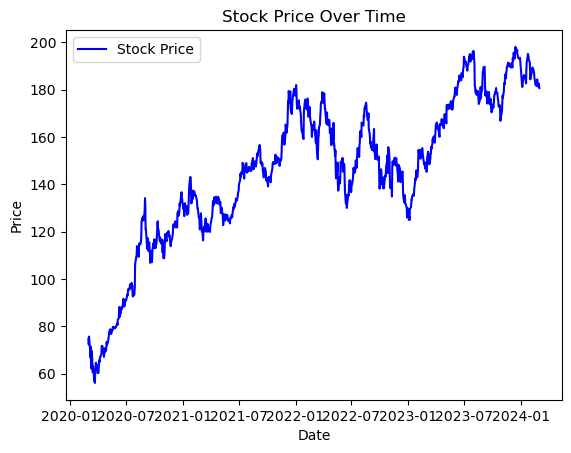

In [2]:
choose_analysis_or_model()

In [ ]:

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def load_data(ticker, start_date, end_date):
    print(f"Loading data for {ticker} from {start_date} to {end_date}...")
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        if data.empty:
            print("No data found for the given range. Please check the ticker or date range.")
            return None
        print(f"Data successfully loaded! Total days of data: {len(data)}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


In [ ]:

def main_menu(data):
    print("\nMain Menu:")
    print("1. Analysis Using Plots")
    print("2. Analysis Using RNN Models")
    choice = int(input("Enter your choice (1 or 2): "))
    
    if choice == 1:
        plot_analysis(data)
    elif choice == 2:
        rnn_analysis(data)
    else:
        print("Invalid choice. Please try again.")
        main_menu(data)


In [ ]:

def plot_analysis(data):
    print("\nAvailable Plots:")
    print("1. Stock Price Line Plot")
    print("2. Moving Averages (50-Day, 200-Day)")
    print("3. Candlestick Chart")
    print("4. Volume Plot")
    print("5. RSI (Relative Strength Index)")
    print("6. MACD (Moving Average Convergence Divergence)")
    print("7. Bollinger Bands")
    print("8. All Plots")
    
    plot_choices = input("Enter the numbers corresponding to the plots you want to see (e.g., 1,3,5): ").split(",")
    
    if "8" in plot_choices:
        plot_all(data)
    else:
        for choice in plot_choices:
            if choice == "1":
                plot_stock_price(data)
            elif choice == "2":
                plot_moving_averages(data)
            elif choice == "3":
                plot_candlestick(data)
            elif choice == "4":
                plot_volume(data)
            elif choice == "5":
                plot_rsi(data)
            elif choice == "6":
                plot_macd(data)
            elif choice == "7":
                plot_bollinger_bands(data)
            else:
                print(f"Invalid choice: {choice}")


In [ ]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

def rnn_analysis(data):
    print("\nRNN Analysis:")
    time_step = int(input("Enter the time step (e.g., 50 days): "))
    train_split = float(input("Enter the train-test split ratio (e.g., 0.7 for 70%): "))
    
    # Feature engineering
    close_prices = data['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_prices)
    
    train_size = int(len(scaled_data) * train_split)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size - time_step:]
    
    def create_dataset(data, time_step):
        X, y = [], []
        for i in range(len(data) - time_step):
            X.append(data[i:(i + time_step), 0])
            y.append(data[i + time_step, 0])
        return np.array(X), np.array(y)
    
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    print(f"Observations created: {len(X_train)} for training, {len(X_test)} for testing.")
    
    # User selects model
    print("\nChoose an RNN Model:")
    print("1. LSTM")
    print("2. GRU")
    print("3. Bidirectional LSTM")
    # Add more models here as needed
    
    model_choice = int(input("Enter the number corresponding to your choice: "))
    if model_choice == 1:
        predictions, model = train_lstm(X_train, y_train, X_test)
    elif model_choice == 2:
        predictions, model = train_gru(X_train, y_train, X_test)
    elif model_choice == 3:
        predictions, model = train_bidirectional_lstm(X_train, y_train, X_test)
    else:
        print("Invalid choice.")
        return
    
    # Display RMSE and results
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(mean_squared_error(actual_prices, predictions))
    print(f"RMSE: {rmse}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(actual_prices, color='blue', label='Actual Prices')
    plt.plot(predictions, color='red', label='Predicted Prices')
    plt.title("Actual vs Predicted Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
    
    # Allow user to refine parameters or proceed to future predictions
    refine_choice = input("Do you want to refine parameters to improve RMSE? (yes/no): ").lower()
    if refine_choice == "yes":
        rnn_analysis(data)
    else:
        future_days = int(input("Enter the number of future days to predict: "))
        future_predictions = predict_future_prices(model, scaler, scaled_data, time_step, future_days)
        print(f"Future predictions: {future_predictions}")
